In [21]:
# Celda 1

import sqlite3
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descarga las dependencias de NLTK de forma concisa
try:
    nltk.download(['stopwords', 'punkt', 'punkt_tab'], quiet=True)
except Exception as e:
    print(f"Error al descargar NLTK: {e}")

def load_data_from_db(db_name="fightaging_articles.db"):
    """Carga todos los artículos de la base de datos SQLite a un DataFrame."""
    try:
        with sqlite3.connect(db_name) as conn:
            # Carga la tabla completa. Agregamos 'link' para posible uso futuro.
            df = pd.read_sql_query("SELECT * FROM articles", conn)
            
        # Conversión directa a datetime
        df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
        
        print(f"✅ Éxito: Se cargaron {len(df)} artículos desde '{db_name}'.")
        return df
    except Exception as e:
        print(f"❌ Error al cargar datos: {e}")
        return pd.DataFrame()


In [22]:
# Celda 2

# Variables globales/constantes
STOP_WORDS = set(stopwords.words('english'))
# Stop words específicas del dominio (ciencia de datos/envejecimiento)
CUSTOM_STOP_WORDS = [
    'welcome', 'fight', 'also', 'study', 'research', 'aging', 'age', 'may', 
    'however', 'results', 'data', 'found', 'open', 'access', 
    'great', 'deal', 'one', 'even', 'work', 'life', 'people', 'years', 'healthy',
    'well', 'change', 'system', 'individual', 'say', 'come', 'benefit', 'case',
    'time', 'process', 'first', 'many', 'link', 'way'
]    
STOP_WORDS.update(CUSTOM_STOP_WORDS)

def clean_text(text: str) -> str:
    """Limpia el texto: minúsculas, elimina puntuación/números, tokeniza, elimina 
    stop words, y filtra palabras cortas (< 3 letras)."""
    if pd.isna(text) or not text:
        return ""
        
    # Lowercase y remoción de no-letras
    text = re.sub(r'[^a-z\s]', '', str(text).lower())
    
    # Tokenización y filtrado en una sola comprensión de lista
    tokens = word_tokenize(text)
    filtered_tokens = [
        word for word in tokens 
        if word not in STOP_WORDS and len(word) > 2
    ]
    
    return " ".join(filtered_tokens)

# --- EJECUCIÓN PRINCIPAL Y ALMACENAMIENTO ---

if __name__ == "__main__":
    ARTICLES_FILE = "articles_cleaned.pkl"
    articles_df = load_data_from_db()

    if articles_df.empty:
        print("🛑 Terminando: No hay datos para procesar.")
    else:
        # Combinar título y cuerpo y aplicar limpieza a todo el corpus
        articles_df['full_text'] = articles_df['title'] + ' ' + articles_df['body'].fillna('')
        
        print(f"\nLimpiando y preprocesando {len(articles_df)} artículos...")
        # Aplicamos la función de limpieza a TODA la columna
        articles_df['cleaned_text'] = articles_df['full_text'].apply(clean_text)

        # 🎯 CORRECCIÓN CRÍTICA: Guardar el DataFrame completo para las celdas futuras
        articles_df.to_pickle(ARTICLES_FILE)
        print(f"\n✅ Éxito: DataFrame limpio guardado en '{ARTICLES_FILE}'.")
        
        # Muestra una comparación concisa (primer artículo no vacío)
        try:
            sample_idx = articles_df['full_text'].str.strip().astype(bool).idxmax() # Encuentra la primera fila no vacía
            print("\n--- Ejemplo de Limpieza ---")
            print(f"Original: {articles_df.loc[sample_idx, 'full_text'][:100]}...") 
            print(f"Limpio: {articles_df.loc[sample_idx, 'cleaned_text'][:100]}...")
        except:
            print("No se pudo mostrar el ejemplo.")

✅ Éxito: Se cargaron 18753 artículos desde 'fightaging_articles.db'.

Limpiando y preprocesando 18753 artículos...

✅ Éxito: DataFrame limpio guardado en 'articles_cleaned.pkl'.

--- Ejemplo de Limpieza ---
Original: Welcome to Fight Aging! Welcome aboard! This new collaborative blog will extend the slightly bloggis...
Limpio: aboard new collaborative blog extend slightly bloggish daily news longevity meme friendly informativ...


In [23]:
# Celda 3

import pandas as pd

ARTICLES_FILE = "articles_cleaned.pkl"

try:
    # Cargar el DataFrame desde el archivo pickle
    articles_df = pd.read_pickle(ARTICLES_FILE)
    
    print(f"✅ Archivo '{ARTICLES_FILE}' cargado exitosamente.")

    # Ajuste de opciones de visualización para contexto de Jupyter
    pd.set_option('display.max_colwidth', 100) 
    pd.set_option('display.width', 1000)
    
    # --- Exploración Concisa ---
    
    ## 1. Información General
    print("\n" + "="*50 + "\n## 1. Información General (articles_df.info()) ##")
    articles_df.info()

    ## 2. Primeras Filas y Columnas Clave
    print("\n" + "="*50 + "\n## 2. Vista de Datos (Primeros 5 Registros) ##")
    print(articles_df[['publish_date', 'title', 'cleaned_text']].head())

except FileNotFoundError:
    print(f"❌ Error: El archivo '{ARTICLES_FILE}' no se encontró. Ejecuta primero la Celda 2.")
except Exception as e:
    print(f"❌ Ocurrió un error al cargar el archivo: {e}")

✅ Archivo 'articles_cleaned.pkl' cargado exitosamente.

## 1. Información General (articles_df.info()) ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18753 entries, 0 to 18752
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             18753 non-null  int64         
 1   url            18753 non-null  object        
 2   publish_date   18753 non-null  datetime64[ns]
 3   title          18753 non-null  object        
 4   body           18753 non-null  object        
 5   quotes         18753 non-null  object        
 6   external_link  12728 non-null  object        
 7   full_text      18753 non-null  object        
 8   cleaned_text   18753 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 1.3+ MB

## 2. Vista de Datos (Primeros 5 Registros) ##
  publish_date                                   title                                                      

/tmp/ipykernel_95388/4284231605.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='conteo', y='bigrama', data=bigram_df, palette='viridis')


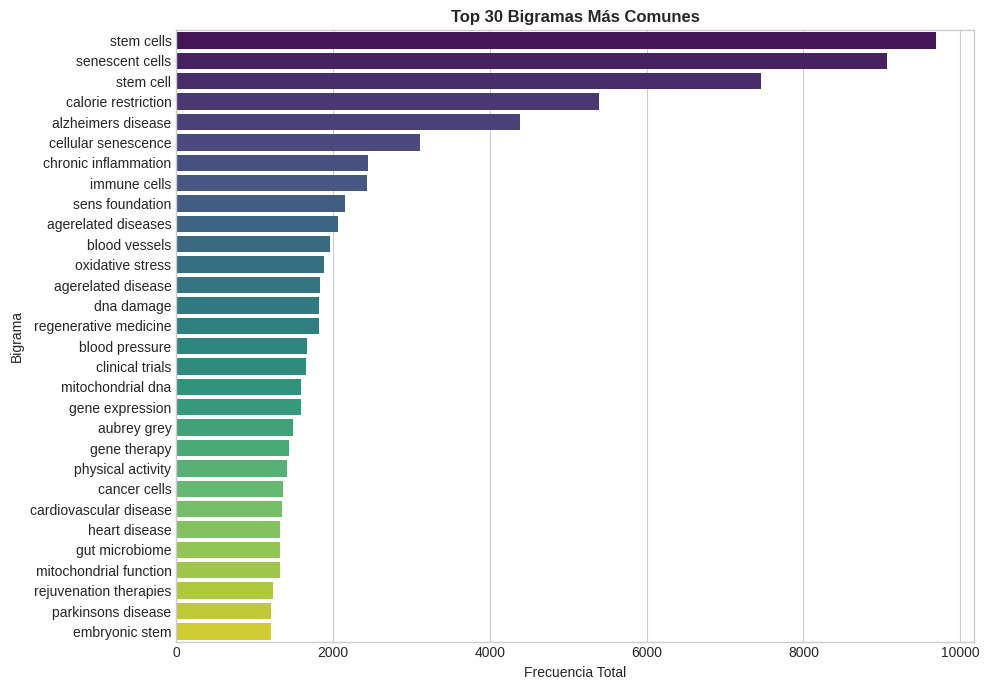

In [24]:
# Celda 4

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Carga (asumiendo que 'articles_cleaned.pkl' está disponible)
try:
    df = pd.read_pickle("articles_cleaned.pkl")
except:
    print("Error al cargar el DataFrame. Asegúrate de ejecutar la Celda 2.")
    # Si falla, salir de la celda
    # raise

## Análisis de Bigramas
# Vectorizar el texto limpio para obtener los 30 bigramas más frecuentes
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=30)
bigram_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Sumar frecuencias y crear DataFrame de resultados
sum_bigrams = bigram_matrix.sum(axis=0)
words_freq = [
    (word, sum_bigrams[0, idx]) 
    for word, idx in vectorizer.vocabulary_.items()
]
bigram_df = pd.DataFrame(
    sorted(words_freq, key=lambda x: x[1], reverse=True), 
    columns=['bigrama', 'conteo']
)

## Visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 7))
sns.barplot(x='conteo', y='bigrama', data=bigram_df, palette='viridis')
plt.title('Top 30 Bigramas Más Comunes', weight='bold')
plt.xlabel('Frecuencia Total')
plt.ylabel('Bigrama')
plt.tight_layout()
plt.savefig('top_bigrams.png', dpi=300)
plt.show()

Generando nube de palabras general...


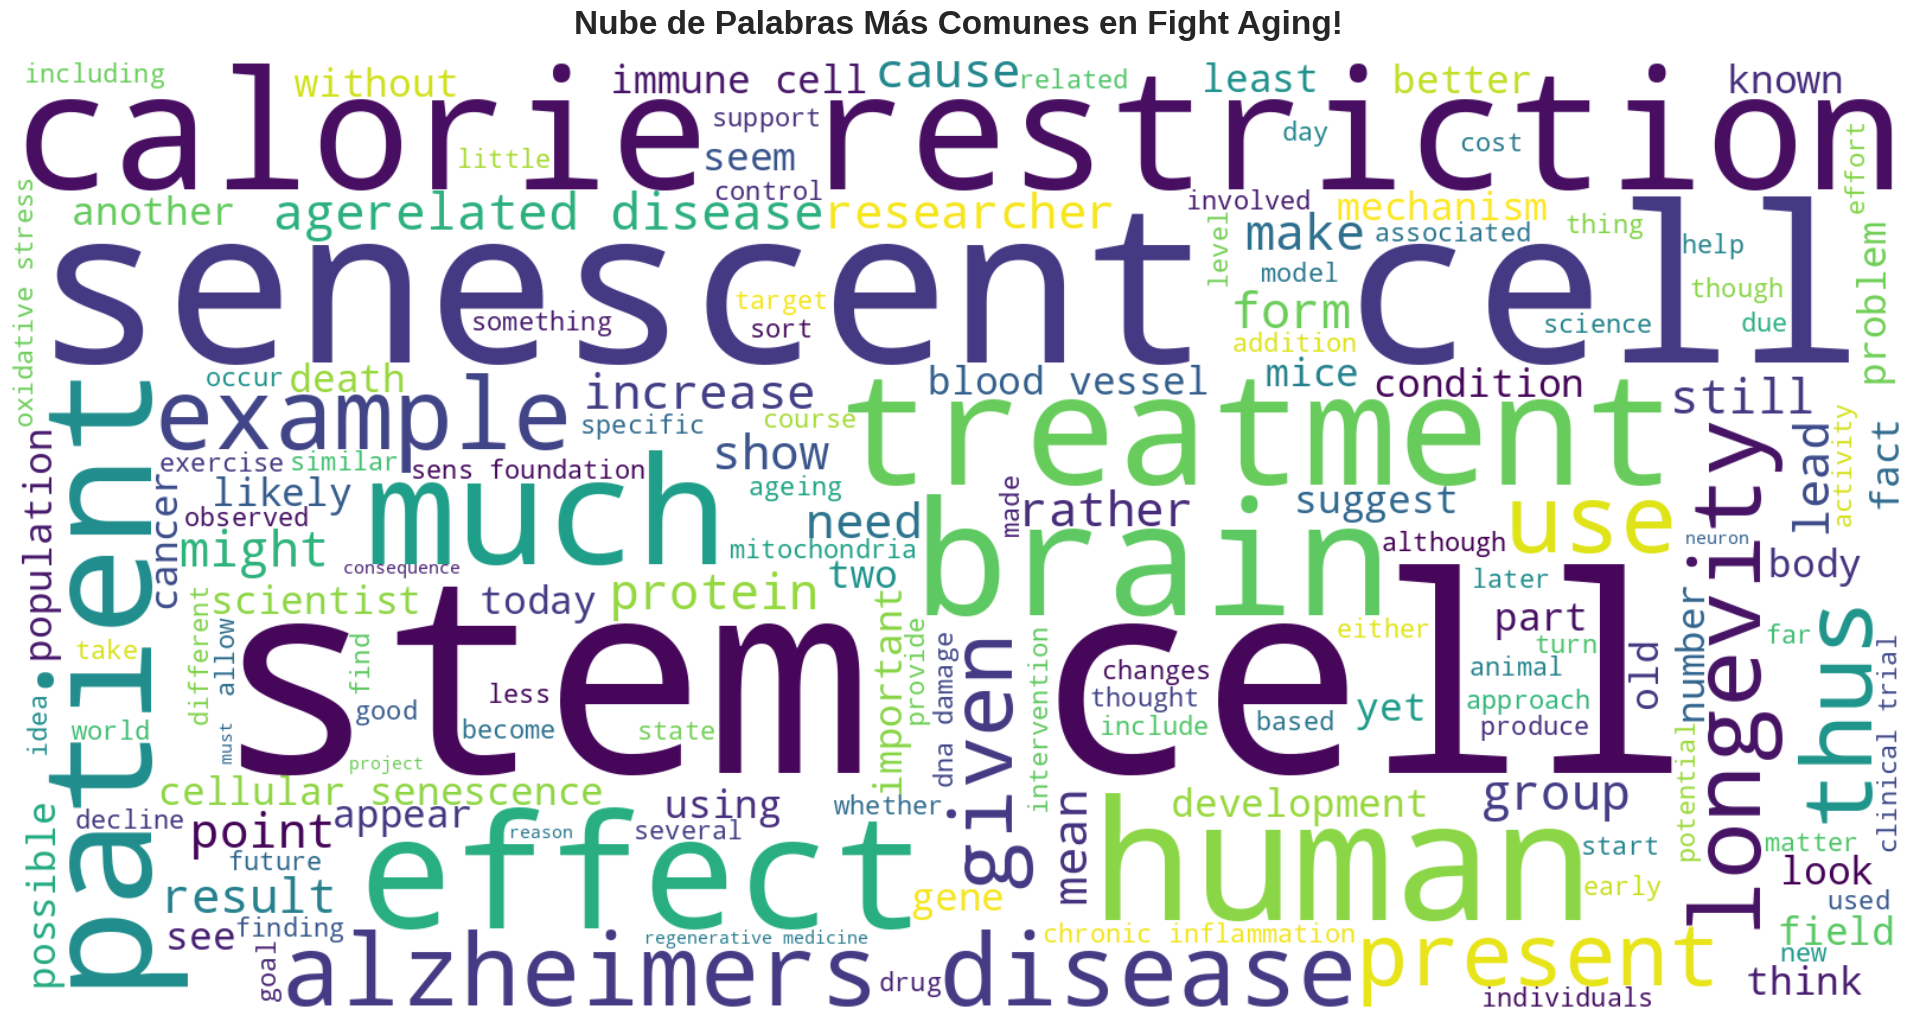

In [25]:
# Celda 5
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Carga tu DataFrame limpio (el que regeneraste con la lista de stop words corregida)
df = pd.read_pickle("articles_cleaned.pkl")

print("Generando nube de palabras general...")

# Une todo el texto limpio en un solo string gigante
full_text_corpus = " ".join(df['cleaned_text'])

# Crea el objeto WordCloud
wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color='white', 
    colormap='viridis',
    max_words=150 # Puedes ajustar el número de palabras a mostrar
).generate(full_text_corpus)

# Muestra y guarda la imagen
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # No mostrar los ejes
plt.title('Nube de Palabras Más Comunes en Fight Aging!', fontsize=24, weight='bold', pad=20)
plt.tight_layout(pad=0)
plt.savefig('wordcloud_general.png', dpi=300)
plt.show()

Analizando bigramas para la Era Inicial (2004-2010)...


/tmp/ipykernel_95388/949411638.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='conteo', y='bigrama', data=bigram_df, ax=axes[i], palette='viridis')


Analizando bigramas para la Era Media (2011-2017)...


/tmp/ipykernel_95388/949411638.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='conteo', y='bigrama', data=bigram_df, ax=axes[i], palette='viridis')


Analizando bigramas para la Era Reciente (2018-2025)...


/tmp/ipykernel_95388/949411638.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='conteo', y='bigrama', data=bigram_df, ax=axes[i], palette='viridis')


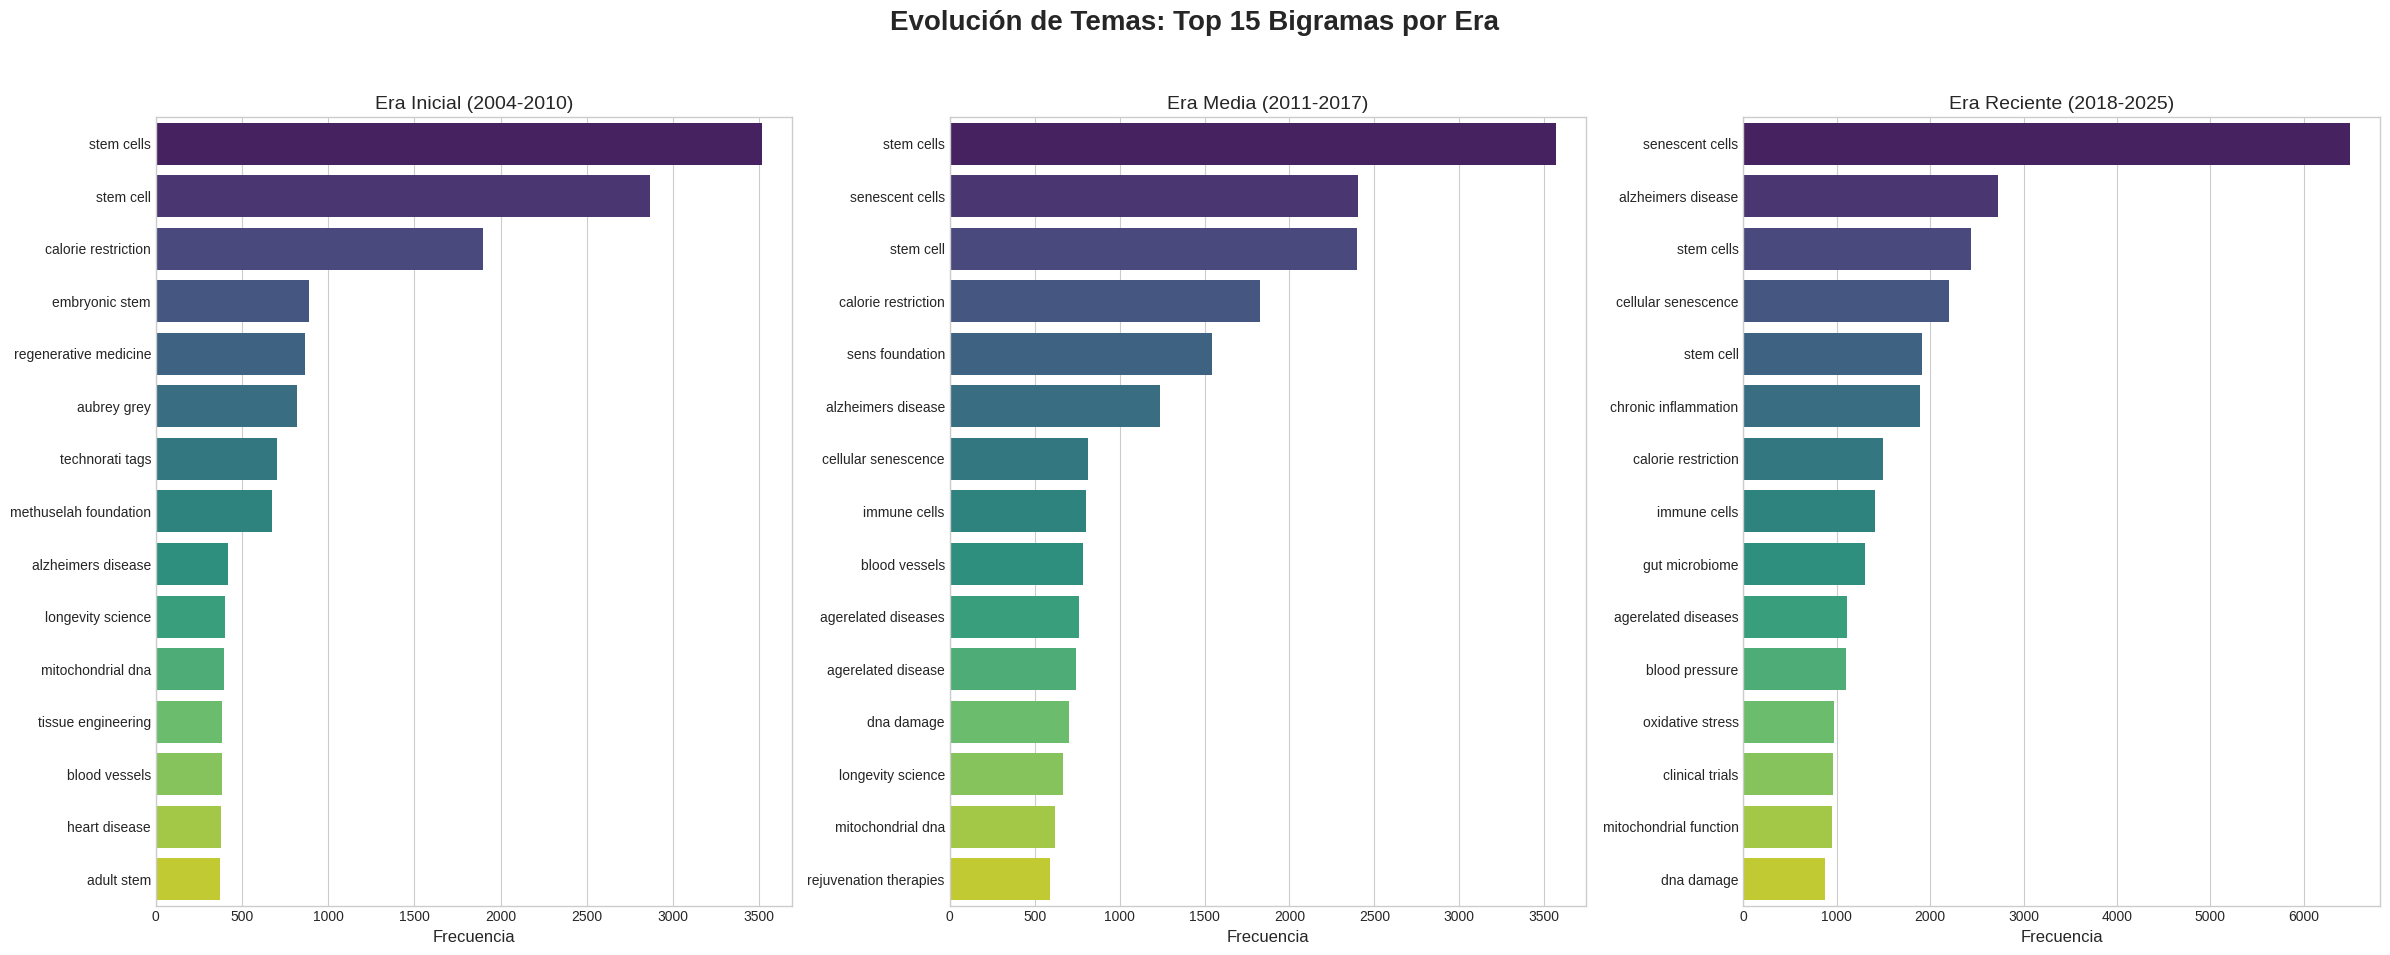

In [26]:
# Celda 6

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Carga (asumiendo 'articles_cleaned.pkl' disponible)
try:
    df = pd.read_pickle("articles_cleaned.pkl")
except:
    print("Error al cargar el DataFrame. Asegúrate de ejecutar la Celda 2.")
    # Si falla, salir de la celda
    # raise

# Definición de Eras
eras = {
    'Era Inicial (2004-2010)': (2004, 2010),
    'Era Media (2011-2017)': (2011, 2017),
    'Era Reciente (2018-2025)': (2018, 2025)
}

# Configuración de la figura y el vectorizador
fig, axes = plt.subplots(1, 3, figsize=(24, 10)) # Reducción de tamaño para mejor visualización
fig.suptitle('Evolución de Temas: Top 15 Bigramas por Era', fontsize=20, weight='bold')

vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=15)

for i, (era_name, (start_year, end_year)) in enumerate(eras.items()):
    print(f"Analizando bigramas para la {era_name}...")
    
    # Filtrar el DataFrame
    era_filter = (df['publish_date'].dt.year >= start_year) & (df['publish_date'].dt.year <= end_year)
    df_era = df[era_filter]
    
    if df_era.empty or df_era['cleaned_text'].astype(bool).sum() == 0:
        print(f"  Advertencia: No hay datos o texto limpio en la {era_name}.")
        continue
        
    # Calcular Bigramas
    bigram_matrix = vectorizer.fit_transform(df_era['cleaned_text'].astype(str))
    sum_bigrams = bigram_matrix.sum(axis=0)
    
    words_freq = sorted(
        [(word, sum_bigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()], 
        key=lambda x: x[1], 
        reverse=True
    )
    bigram_df = pd.DataFrame(words_freq, columns=['bigrama', 'conteo'])
    
    # Dibujar el gráfico
    sns.barplot(x='conteo', y='bigrama', data=bigram_df, ax=axes[i], palette='viridis')
    axes[i].set_title(era_name, fontsize=14)
    axes[i].set_xlabel('Frecuencia', fontsize=12)
    axes[i].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('bigrams_por_era.png', dpi=300)
plt.show()